### Gaussian Mixture and EM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import pairwise_distances

% matplotlib inline

In [2]:
def make_clusters(skew=True, *arg,**kwargs):
    X, y = datasets.make_blobs(*arg,**kwargs)
    if skew:
        nrow = X.shape[1]
        for i in np.unique(y):
            X[y==i] = X[y==i].dot(np.random.random((nrow,nrow))-0.5)
    return X,y

def scatter(X, color=None, ax=None, centroids=None, **kwargs):
#     assert X.shape[1]==2
#     if color is not None:
#         assert X.shape[0]==color.shape[0]
#         assert len(color.shape)==1
    if not ax:
        _, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=color, **kwargs)
    if centroids is not None:
        ax.scatter(centroids[:,0],centroids[::,1],s=350, c=range(centroids.shape[0]), **kwargs)

(1500, 2)
(1500,)
[0 1 2 3]


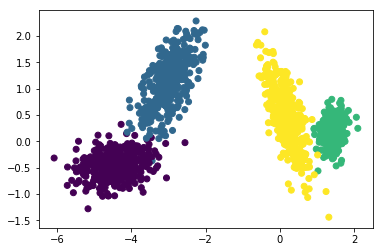

In [3]:
np.random.seed(6)

K = 4
X, y = make_clusters(skew=True, n_samples=1500, centers=K)
answer = y
print(X.shape)
print(y.shape)
print(np.unique(y))
scatter(X, y)

#### Gaussian Mixture using EM

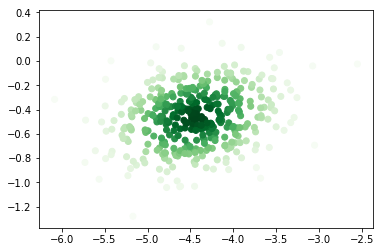

In [4]:
# firstly, we need to compute the multivariate gaussian pdf

# def multivariate_gaussian_pdf(data, mean, cov):
#     assert len(mean.shape)==1 and len(cov.shape)==2
#     logpdf = -((data-mean).dot(np.linalg.inv(cov))*(data-mean)).sum(axis=1)/2
#     pdf = np.exp(logpdf)
#     pdf /= np.sqrt(np.linalg.det(2*np.pi*cov))
#     return pdf

from scipy.stats import multivariate_normal
multivariate_gaussian_pdf = multivariate_normal.pdf

data = X[y==0]
mean = data.mean(axis=0)
cov = np.cov(data.T)
plt.scatter(data[:,0],data[:,1],c=multivariate_gaussian_pdf(data, mean, cov), cmap="Greens")

In [5]:
def contours_2d(data, means, covs, y=None, ax=None):
    assert data.shape[1]==2
    
    # generate grid
    delta = .025
    margin = .2
    xmax, ymax = data.max(axis=0)
    xmin, ymin = data.min(axis=0)
    axis_X, axis_Y = np.meshgrid(np.arange(xmin-margin, xmax+margin, delta), np.arange(ymin-margin, ymax+margin, delta))

    if ax is None:
        _, ax = plt.subplots(figsize = (6,6))
    k = len(means)
    cmap = 'bgrcmyk'
    if k <= len(cmap):
        col = np.array(list(cmap))
        if y is not None:
            y = col[y]
    else:
        col = [None for _ in range(k)]
    scatter(X, y, ax=ax)
    for i in range(k):
        Z = multivariate_gaussian_pdf(np.array(list(zip(axis_X.flatten(),axis_Y.flatten()))), means[i], covs[i]).reshape(axis_X.shape) + 1
        ax.contour(axis_X, axis_Y, Z, colors = col[i])

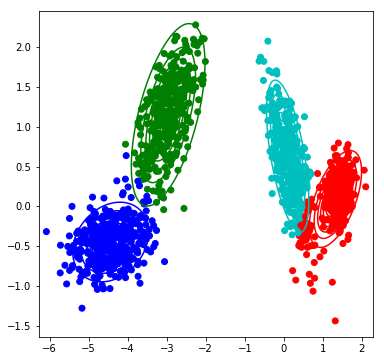

In [9]:
# full covariances initialization
np.random.seed(10)

# assign to the clusters (M-step)
def get_assignments(X, centroids):
    dist = pairwise_distances(X, centroids)
    assign = np.argmin(dist,axis=1)
    return assign

# compute the new centroids (E-step)
def get_centroids(X, assignments):
    centroids = []
    for i in np.unique(assignments):
        centroids.append(X[assignments==i].mean(axis=0))     
    return np.array(centroids)
def init_random(X, K):
    center_index = np.random.choice(range(X.shape[0]), K)
    centroids = X[center_index,:]
    return centroids

def KMeans(X, centroids, n_iterations=5, axes=None):
    if axes is not None:
        axes = axes.flatten()
    for i in range(n_iterations):
        assignments = get_assignments(X, centroids)
        centroids = get_centroids(X, assignments)
        if axes is not None:
            scatter(X, assignments, ax=axes[i], centroids=centroids)
            axes[i].set_title(i)
    return assignments, centroids
def initialize(data, centroids, assignments=None):
    K = centroids.shape[0]
    means = centroids
    weights = np.ones(K) / K
    weights[0]+=1
    if assignments is not None:
        covs = []
        for i in np.unique(assignments):
            weights[i] = data[assignments==i].shape[0]
            covs.append(np.cov(data[assignments==i].T))
    else:
        covs = np.array([np.cov(data.T)]*K)
    weights /= weights.sum()
    return means, covs, weights

assignments = None
centroids = init_random(X, K)
assignments, centroids = KMeans(X, centroids)
means, covs, weights = initialize(X, centroids, assignments)
contours_2d(X, means, covs, y=assignments)